<a href="https://colab.research.google.com/github/BKover99/Pseudovisium/blob/main/Paper%20figures/Fig2A_CosMx_Mouse_Brain_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing packages and getting the links for the datasets.

In [ ]:
!wget https://github.com/BKover99/Pseudovisium/raw/main/Datasets_all.xlsx
!pip install Pseudovisium -q
!pip install pympler -q
!pip install spatialAUC -q


--2024-06-17 19:32:04--  https://github.com/BKover99/Pseudovisium/raw/main/Datasets_all.xlsx
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BKover99/Pseudovisium/main/Datasets_all.xlsx [following]
--2024-06-17 19:32:05--  https://raw.githubusercontent.com/BKover99/Pseudovisium/main/Datasets_all.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42301 (41K) [application/octet-stream]
Saving to: ‘Datasets_all.xlsx’

Datasets_all.xlsx   100%[===================>]  41.31K  --.-KB/s    in 0.04s   

2024-06-17 19:32:05 (1.06 MB/s) - ‘Datasets_all.xlsx’ saved [42301/42301]

     ━━━━━━━━━━━━━━━━━━

Loading packages and defining two functions that can locate files of interest. Note that for the analysis of a single dataset, using these functions is not necessary. But it was more convenient to copy all of these utilities from the other notebooks of the paper.

In [ ]:
import pandas as pd
from os import system
import os
import time
import squidpy as sq
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from pympler import asizeof
import json
import seaborn as sns
import scipy.stats as stats
import sklearn.metrics as metrics
import shutil
import subprocess
import concurrent.futures


def find_csv_with_transcript(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if ((file.endswith('.csv') or file.endswith('.csv.gz')) and (('transcript' in file.lower() or 'tx' in file.lower()))) and 'macosx' not in root.lower():
                return os.path.join(root, file)
    return None

def find_any_file_within_folder(folder_path,end):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            #if (file.endswith(end) or file.endswith(end+"") and 'macosx' not in root.lower():
            if (file.endswith(end) or file.endswith(end+".gz")) and 'macosx' not in root.lower():
                return os.path.join(root, file)
    return None

Finding the dataset required for this Colab notebook.

In [ ]:
datasets = pd.read_excel("/content/Datasets_all.xlsx")
datasets_to_use = datasets[datasets["Brain case study"]==1]
#remove those without link
datasets_to_use = datasets_to_use[~datasets_to_use["Onedrive_link"].isna()]
datasets_to_use.reset_index(drop=True,inplace=True)
datasets_to_use

,Author,Year,Paper_DOI,Link_to_dataset,Onedrive_link,Name,Technology,Tissue,Species,Visium_xenium_notebook,PV_workflow_comparison,Comparing_all_tech,Pulmonary Xenium,Cosmx_lung,Dataset_merge_visium,Brain case study,Just Visium example
0,Nanostring,2023,NaN,https://nanostring.com/products/cosmx-spatial-...,https://ywobqw.bl.files.1drv.com/y4mnkgdMt9PQD...,CosMx_mouse_brain,CosMx,Brain,Mouse,0,1,1,0,0,1,1,0


Downloading and unzipping the data

In [ ]:
def download_and_unzip(dataset):
    try:
        download_link = dataset["Onedrive_link"]
        name = dataset["Name"]
        print(f"Processing dataset: {name}")
        print(f"Download link: {download_link}")

        command = "wget {}".format(download_link)
        subprocess.run(command, shell=True, check=True)

        filename = download_link.split("com/")[-1]
        archive_name = filename.split("/")[-1]

        if name == "Xenium_whole_mouse_pup":
            filename = "Xenium_V1_mouse_pup_outs.zip"

        try:
            command_unzip = "unzip -d /content/{} /content/{}".format(name, filename)
            print(command_unzip)
            subprocess.run(command_unzip, shell=True, check=True)
            print("Successfully unzipped {}.".format(archive_name))
            os.remove("/content/{}".format(filename))  # Remove the zip file
        except subprocess.CalledProcessError:
            print("Failed to unzip {}. Attempting other methods.".format(archive_name))

            try:
                command_gunzip = "gunzip -d /content/{} /content/{}".format(name, filename)
                subprocess.run(command_gunzip, shell=True, check=True)
                print("Successfully gunzipped {}.".format(archive_name))
                os.remove("/content/{}".format(filename))   # Remove the zip file
            except subprocess.CalledProcessError:
                print("Failed to gunzip {}. Attempting other methods.".format(archive_name))

                try:
                    os.makedirs("/content/{}".format(name), exist_ok=True)
                    command_untar = "tar -xvf /content/{} -C /content/{}".format(filename, name)
                    subprocess.run(command_untar, shell=True, check=True)
                    print("Successfully untarred {}.".format(archive_name))
                    os.remove("/content/{}".format(filename))   # Remove the zip file
                except subprocess.CalledProcessError:
                    try:
                      command_untar = "tar -xvzf /content/{} -C /content/{}".format(filename, name)
                      subprocess.run(command_untar, shell=True, check=True)
                      print("Successfully untarred {}.".format(archive_name))
                      os.remove("/content/{}".format(filename))   # Remove the zip file
                    except:
                      print("All methods failed to extract {}.".format(archive_name))
    except KeyError as e:
        print(f"Error: Missing required column in dataset: {str(e)}")
    except subprocess.CalledProcessError as e:
        print(f"Error: Command failed: {str(e)}")
    except Exception as e:
        print(f"Error: An unexpected error occurred: {str(e)}")

# Create a thread pool with a maximum of 10 threads
with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
    # Submit download and unzip tasks to the thread pool
    futures = [executor.submit(download_and_unzip, row.to_dict()) for _, row in datasets_to_use.reset_index(drop=True).iterrows()]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)


Processing dataset: CosMx_mouse_brain
Download link: https://ywobqw.bl.files.1drv.com/y4mnkgdMt9PQDjy_KeoASubj2GkF8Ro0xggVKMegwWL2EqBQaVXMq6-28emVeQKpe0pY0vf-ZaMWUR1jhZTcg555duknK_p6Se7HsxcI7b3UdOPpNAQLS7_XUQ9lK2T4IIfsfLe4wGjlWPXkp5Jb0LL9z23hgY32LnPowmzrS585zsjjDLKCZBLP6-lyhTHfG3ug-xMX8wGjNb2GWaUYXJzYQ
unzip -d /content/CosMx_mouse_brain /content/y4mnkgdMt9PQDjy_KeoASubj2GkF8Ro0xggVKMegwWL2EqBQaVXMq6-28emVeQKpe0pY0vf-ZaMWUR1jhZTcg555duknK_p6Se7HsxcI7b3UdOPpNAQLS7_XUQ9lK2T4IIfsfLe4wGjlWPXkp5Jb0LL9z23hgY32LnPowmzrS585zsjjDLKCZBLP6-lyhTHfG3ug-xMX8wGjNb2GWaUYXJzYQ
Successfully unzipped y4mnkgdMt9PQDjy_KeoASubj2GkF8Ro0xggVKMegwWL2EqBQaVXMq6-28emVeQKpe0pY0vf-ZaMWUR1jhZTcg555duknK_p6Se7HsxcI7b3UdOPpNAQLS7_XUQ9lK2T4IIfsfLe4wGjlWPXkp5Jb0LL9z23hgY32LnPowmzrS585zsjjDLKCZBLP6-lyhTHfG3ug-xMX8wGjNb2GWaUYXJzYQ.


Running the hexagonal binning using Pseudovisium generate

In [ ]:
from Pseudovisium.pseudovisium_generate import generate_pv
output_path="/content/"
hexagon_size=50
max_workers=10

start_pv = time.time()
technology = datasets_to_use["Technology"].values[0]
name=datasets_to_use["Name"].values[0]
csv_file = find_csv_with_transcript("/content/"+name+"/")
df = pd.read_csv(csv_file)

  # Create a new column called 'cell' by concatenating 'fov' and 'cell_ID' columns
df['cell'] = df['fov'].astype(str) + '_' + df['cell_ID'].astype(str)

  # Save the updated DataFrame back to the original CSV file
df.to_csv(csv_file, index=False)
technology = "CosMx"
ctu= 0.12028
print(ctu)

generate_pv(csv_file=csv_file,
            hexagon_size=hexagon_size,
            output_path=output_path,
            batch_size=10000000,
            technology=technology,
            max_workers=max_workers,
            project_name=name,
            shift_to_positive=True,
            coord_to_um_conversion=ctu)

<ipython-input-6-44f78141f31d>:10: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


0.12028
You are using version:  ['Pseudovisium==0.0.42']
Date:  2024-06-17
Technology is Nanostring. Going forward with default column names.
Quality filter is set to False
Quality counting per hexagon is set to False
Quality counting per probe is set to False
Created temporary directory /tmp/tmp_hexa6r_v3qv7
Now creating batches
Created batch 1
Created batch 2
Created batch 3
Created batch 4
Created batch 5
Created batch 6
Created batch 7
Created batch 8
Created batch 9
Created batch 10
Created batch 11
Created batch 12
Finished preprocessing. Total batches created: 12
Processing batches using 8 processes


Processing batches: 100%|██████████| 12/12 [04:11<00:00, 20.97s/batch]


Creating pseudovisium folder in output path:/content//pseudovisium/CosMx_mouse_brain
Creating scalefactors_json.json file in spatial folder.
Creating barcodes.tsv.gz file in spatial folder.
Creating tissue_positions_list.csv file in spatial folder.
Creating pv_cell_hex.csv file in spatial folder.
No quality information provided. Skipping quality information files.
No quality information provided. Skipping quality information files.
Creating features.tsv.gz file in spatial folder.
Putting together the matrix.mtx file
Total matrix count: 116159827.0
Number of unique hexagons: 4062
Creating matrix.mtx.gz file in spatial folder.


/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_generate.py:795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hexagon_cell_counts["hexagon_id"] = hexagon_cell_counts["hexagon_id"] + 1


Putting together the filtered_feature_bc_matrix.h5 file
No image file provided. Drawing tissue positions on a white background.
Creating arguments.json file in output path.
Time taken: 879.3983042240143 seconds
Searching for temporary batch files in: /tmp
No remaining temporary batch files found.


In [ ]:
results = {}

Giant codeblock where all the functions are defined. These are the same ones that are used in the larger notebook for Figure 2B and Figure 5, and were simply pasted here into a single block. Briefly, these functions perform the processing, filtering, clustering, and analysis of various metrics on the brain dataset.


/content/CosMx_mouse_brain/
Loading in
/content/CosMx_mouse_brain/
/content/CosMx_mouse_brain/mouse brain parts/Brain_files/Run1000_S1_Half_exprMat_file.csv


<ipython-input-46-efaa1e9178f4>:77: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_pv.obs["sum"]= np.array(np.sum(adata_pv.X,axis=1)).flatten()


Processing


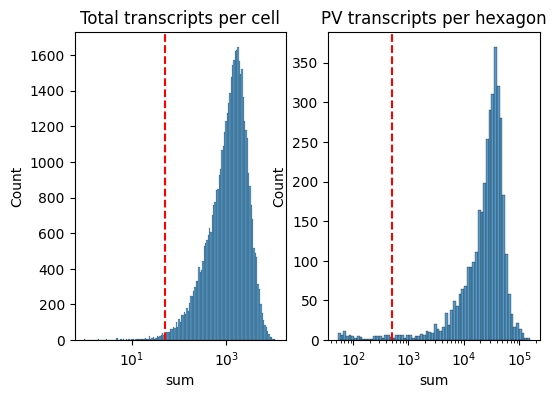

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Processing fullres data
Starting PCA
Starting leiden clustering
Processing pseudovisium data
Starting PCA
Starting leiden clustering
Trying resolution: 0.01
Difference in number of clusters: 11
Trying resolution: 0.012
Difference in number of clusters: 11
Trying resolution: 0.0144
Difference in number of clusters: 10
Trying resolution: 0.01728
Difference in number of clusters: 10
Trying resolution: 0.020736
Difference in number of clusters: 10
Trying resolution: 0.0248832
Difference in number of clusters: 10
Trying resolution: 0.02985984
Difference in number of clusters: 10
Trying resolution: 0.035831808
Difference in number of clusters: 10
Trying resolution: 0.0429981696
Difference in number of clusters: 9
Trying resolution: 0.05159780351999999
Difference in number of clusters: 9
Trying resolution: 0.06191736422399999
Difference in number of clusters: 8
Trying resolution: 0.07430083706879999
Difference in number of clusters: 8
Trying resolution: 0.08916100448255998
Difference in numbe

  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fullres calculation - Time: 118.48
Pseudovisium calculation - Time: 7.35
Geary's C


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fullres calculation - Time: 98.64
Pseudovisium calculation - Time: 6.96
GSEA


/usr/local/lib/python3.10/dist-packages/gseapy/msigdb.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]
/usr/local/lib/python3.10/dist-packages/gseapy/msigdb.py:72: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fullres calculation - Time: 13.29
Pseudovisium calculation - Time: 1.26


<ipython-input-46-efaa1e9178f4>:441: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closest_hex_leiden.append(adata_pseudov.obs[col2][closest_hex])


ARI: 0.43911207501477484


/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


Markers
Sum of Squared Deviation: 1.8365141196606907
Corrs
Intercept: -0.036962955088849093
Slope: 1.3410129290313033
{'CosMx_mouse_brain': {'loading_time_fr': 4.372035980224609, 'loading_time_pv': 0.18593454360961914, 'fullres_time_to_leiden': 21.031643629074097, 'pv_time_to_leiden': 0.570845365524292, 'fullres_size': 554.7889633178711, 'pv_size': 64.79703521728516, 'fullres_size_dense': 355.634765625, 'pv_size_dense': 13.992919921875, 'moransi_r': 0.8737635213362861, 'moransi_p': 3.694392078952911e-302, 'moransi_time_fr': 118.47581243515015, 'moransi_time_pv': 7.351153612136841, 'gearyc_r': 0.848040742231708, 'gearyc_p': 1.926151943625017e-266, 'gearyc_time_fr': 98.64168787002563, 'gearyc_time_pv': 6.962305068969727, 'gsea_r': 0.811348844311263, 'gsea_p': 4.885297182858336e-17, 'gsea_time_fr': 47.10919547080994, 'gsea_time_pv': 3.9073431491851807, 'ari': 0.43911207501477484, 'intercept_corr': -0.036962955088849093, 'slope_corr': 1.3410129290313033, 'ssd_coexp': 1.8365141196606907}}


In [ ]:
def load_in_fullres(folder, technology, x_col, y_col,ctu=0.12028):
    """
    Load full resolution data based on the technology.

    Args:
        folder (str): The path to the folder containing the data.
        technology (str): The technology used for the data (e.g., "Xenium", "Vizgen", "Visium_HD", "Curio", "Nanostring", "CosMx").
        x_col (str): The column name for the x-coordinate (only used for Curio technology).
        y_col (str): The column name for the y-coordinate (only used for Curio technology).
        ctu (float, optional): The coordinate to micron conversion factor (only used for CosMx technology). Default is 0.12028.

    Returns:
        AnnData: The loaded full resolution data.
    """

    if technology == "Nanostring" or technology == "CosMx":
        try:
            print(folder)
            counts_file = find_any_file_within_folder(folder,"exprMat_file.csv")
            meta_file =  find_any_file_within_folder(folder,"metadata_file.csv")
            fov_file = find_any_file_within_folder(folder,"fov_positions_file.csv")
            print(counts_file)

            adata_fullres = sq.read.nanostring(
                path="",
                    counts_file=counts_file,
                    meta_file=meta_file,
                    #fov_file=fov_file,
            )

        except:
            #first command -> locate to folder folder
            fov_file = find_any_file_within_folder(folder,"fov_positions_file.csv")
            # extract the third column from the CSV file
            df = pd.read_csv(fov_file)
            #create a column fov which is same as FOV
            df["fov"]=df["FOV"]
            #make it the index
            df.set_index("fov", inplace=True)

            df.to_csv(fov_file, index=True)

            adata_fullres = sq.read.nanostring(
                    path="",
                    counts_file=counts_file,
                    meta_file=meta_file,
                    #fov_file=fov_file,
                )
        adata_fullres.obsm["spatial"] = adata_fullres.obs[["CenterX_global_px","CenterY_global_px"]].to_numpy()

        adata_fullres.obsm["spatial"]=adata_fullres.obsm["spatial"]*ctu

    x_min = min(adata_fullres.obsm["spatial"][:,0])
    y_min = min(adata_fullres.obsm["spatial"][:,1])
    if x_min<0:
      adata_fullres.obsm["spatial"][:,0] = adata_fullres.obsm["spatial"][:,0] - x_min
    if y_min<0:
      adata_fullres.obsm["spatial"][:,1] = adata_fullres.obsm["spatial"][:,1] - y_min



    sc.pp.calculate_qc_metrics(adata_fullres, percent_top=(50, 100), inplace=True)
    adata_fullres.obs["sum"]= np.array(np.sum(adata_fullres.X,axis=1)).flatten()

    return adata_fullres

def load_in_pv(folder):
    adata_pv = sq.read.visium(folder,library_id="library_id")
    adata_pv = adata_pv[adata_pv.obs["in_tissue"]==1,]
    adata_pv.obs["sum"]= np.array(np.sum(adata_pv.X,axis=1)).flatten()
    sc.pp.calculate_qc_metrics(adata_pv, percent_top=(50, 100, 200, 300), inplace=True)
    return adata_pv

def load_in_pv(folder):
    adata_pv = sq.read.visium(folder,library_id="library_id")
    adata_pv = adata_pv[adata_pv.obs["in_tissue"]==1,]
    adata_pv.obs["sum"]= np.array(np.sum(adata_pv.X,axis=1)).flatten()
    sc.pp.calculate_qc_metrics(adata_pv, percent_top=(50, 100), inplace=True)
    return adata_pv

def qc_plot(adata_fullres ,adata_pseudov,technology="Xenium"):
        fig, axs = plt.subplots(1, 2, figsize=(6, 4))
        axs[0].set_title("Total transcripts per cell")
        sns.histplot(
            adata_fullres.obs["sum"],
            kde=False,
            ax=axs[0],
            #add log x scale
            log_scale=True,
        )
        axs[1].set_title("PV transcripts per hexagon")
        sns.histplot(
            adata_pseudov.obs["sum"],
            kde=False,
            ax=axs[1],
            #add log x scale
            log_scale=True,
        )
        if technology == "Xenium":
            axs[0].axvline(50, color="red", linestyle="--")
            axs[1].axvline(500, color="red", linestyle="--")
        elif technology == "Vizgen":
            axs[0].axvline(50, color="red", linestyle="--")
            axs[1].axvline(500, color="red", linestyle="--")
        elif technology == "Visium_HD":
            axs[0].axvline(50, color="red", linestyle="--")
            axs[1].axvline(500, color="red", linestyle="--")
        elif technology == "Curio":
            axs[0].axvline(50, color="red", linestyle="--")
            axs[1].axvline(500, color="red", linestyle="--")
        elif technology == "Nanostring" or technology == "CosMx":
            axs[0].axvline(50, color="red", linestyle="--")
            axs[1].axvline(500, color="red", linestyle="--")
        plt.show()

def filter_datasets(adata_fullres ,adata_pseudov, technology="Xenium"):
    #filtering the full resolution data
    adata_fullres.var.index = adata_fullres.var.index.str.upper()
    adata_pseudov.var.index = adata_pseudov.var.index.str.upper()
    adata_fullres.var_names_make_unique()
    adata_pseudov.var_names_make_unique()

    if technology == "Xenium":

        sc.pp.filter_genes(adata_fullres , min_cells=200)
        sc.pp.filter_cells(adata_fullres , min_counts=50)
    elif technology == "Vizgen":

        sc.pp.filter_genes(adata_fullres , min_cells=200)
        sc.pp.filter_cells(adata_fullres , min_counts=50)
    elif technology == "Visium_HD":

        sc.pp.filter_genes(adata_fullres , min_cells=200)
        sc.pp.filter_cells(adata_fullres , min_counts=50)
    elif technology == "Curio":

        sc.pp.filter_genes(adata_fullres , min_cells=200)
        sc.pp.filter_cells(adata_fullres , min_counts=50)
    elif technology == "Nanostring" or technology == "CosMx":

        sc.pp.filter_genes(adata_fullres , min_cells=200)
        sc.pp.filter_cells(adata_fullres , min_counts=50)

    sc.pp.filter_genes(adata_pseudov, min_cells=50)
    sc.pp.filter_cells(adata_pseudov, min_counts=400)

    #only retain gene_expression features
    keep_genes_pv = adata_pseudov.var.index[~adata_pseudov.var.index.str.contains("control|ctrl|code|Code|assign|Assign|pos|NegPrb|neg|Ctrl|blank|Control|Blank|BLANK")].values
    keep_genes_fr = adata_fullres.var.index[~adata_fullres.var.index.str.contains("control|ctrl|code|Code|assign|Assign|pos|NegPrb|neg|Ctrl|blank|Control|Blank|BLANK")].values
    keep_genes = np.intersect1d(keep_genes_pv,keep_genes_fr)
    adata_pseudov=adata_pseudov[:,keep_genes]
    adata_fullres=adata_fullres[:,keep_genes]

    sc.pp.filter_cells(adata_fullres , min_counts=50)
    sc.pp.filter_cells(adata_pseudov, min_counts=400)

    return adata_fullres ,adata_pseudov

def process_to_leiden(adata_fullres, adata_pseudov):
    ram_usage_fr = []
    ram_usage_pv = []

    print("Processing fullres data")
    start_time_fr = time.time()

    sc.pp.normalize_total(adata_fullres, target_sum=1e6)
    adata_fullres.raw = adata_fullres.copy()
    sc.pp.log1p(adata_fullres)
    sc.pp.scale(adata_fullres)

    print("Starting PCA")
    sc.pp.pca(adata_fullres)
    sc.pp.neighbors(adata_fullres, n_neighbors=30, n_pcs=20)

    print("Starting leiden clustering")


    sc.tl.leiden(adata_fullres, resolution=0.3, key_added="leiden",flavor='igraph')
    n_clusters = adata_fullres.obs["leiden"].nunique()


    end_time_fr = time.time()
    time_fr = end_time_fr - start_time_fr

    print("Processing pseudovisium data")
    start_time_pv = time.time()


    sc.pp.normalize_total(adata_pseudov, target_sum=1e6)
    adata_pseudov.raw = adata_pseudov.copy()
    sc.pp.log1p(adata_pseudov)

    sc.pp.scale(adata_pseudov)

    print("Starting PCA")
    sc.pp.pca(adata_pseudov)
    sc.pp.neighbors(adata_pseudov, n_neighbors=30, n_pcs=20)

    print("Starting leiden clustering")


    sc.tl.leiden(adata_pseudov, key_added="leiden",flavor='igraph')


    end_time_pv = time.time()
    time_pv = end_time_pv - start_time_pv

    n_clust_pv = 0
    resolution = 0.01
    best_resolution = 0.5
    n_clust_diff_best = np.abs(n_clust_pv - n_clusters)

    while resolution < 10:
        print("Trying resolution:", resolution)
        sc.tl.leiden(adata_pseudov, resolution=resolution, key_added="leiden",flavor='igraph')
        n_clust_pv = adata_pseudov.obs["leiden"].nunique()
        print("Difference in number of clusters:", np.abs(n_clust_pv - n_clusters))
        n_clust_diff = np.abs(n_clust_pv - n_clusters)
        if n_clust_diff < n_clust_diff_best:
            n_clust_diff_best = n_clust_diff
            best_resolution = resolution
        resolution = resolution * 1.2

    print("Best resolution:", best_resolution)
    sc.tl.leiden(adata_pseudov, resolution=best_resolution, key_added="leiden",flavor='igraph')
    n_clust_pv = adata_pseudov.obs["leiden"].nunique()
    print("Difference in number of clusters:", np.abs(n_clust_pv - n_clusters))

    return adata_fullres, adata_pseudov, time_fr, time_pv



def compare_morans(adata_fullres, adata_pseudov):
    ram_usage_fr = []
    ram_usage_pv = []

    start_time_fr = time.time()

    sq.gr.spatial_neighbors(adata_fullres, radius=250, coord_type="generic", delaunay=True)
    sq.gr.spatial_autocorr(adata_fullres, mode="moran", n_perms=100, n_jobs=4)
    morans_table_fr = adata_fullres.uns["moranI"]

    end_time_fr = time.time()
    time_fr = end_time_fr - start_time_fr

    # Second calculation for pseudovisium
    start_time_pv = time.time()

    sq.gr.spatial_neighbors(adata_pseudov, radius=250, coord_type="generic", delaunay=True)
    sq.gr.spatial_autocorr(adata_pseudov, mode="moran", n_perms=100, n_jobs=4)
    morans_table_pv = adata_pseudov.uns["moranI"]

    end_time_pv = time.time()
    time_pv = end_time_pv - start_time_pv

    print(f"Fullres calculation - Time: {time_fr:.2f}")
    print(f"Pseudovisium calculation - Time: {time_pv:.2f}")


    return adata_fullres, adata_pseudov, morans_table_fr, morans_table_pv, time_fr, time_pv



def plot_moransi_comparison(morans_table_fr, morans_table_pv,name):
    morans_table_fr["data"] = "fullres"
    morans_table_pv["data"] = "pseudovisium"

    morans_table_pv["gene"] = morans_table_pv.index
    morans_table_fr["gene"] = morans_table_fr.index

    # For both dfs, add a column called sig, which is True if pval_norm_fdr_bh is less than 0.05
    morans_table_fr["sig"] = morans_table_fr["pval_norm_fdr_bh"] < 0.05
    morans_table_pv["sig"] = morans_table_pv["pval_norm_fdr_bh"] < 0.05

    #plot df with columns: gene, moranI_fr, moranI_pv, color based on sig
    plot_df = pd.DataFrame()
    #iterate through unique genes in both datasets
    all_genes = np.unique(np.concatenate([morans_table_fr["gene"], morans_table_pv["gene"]]))
    for gene in all_genes:
        #get the moranI values for the gene in both datasets
        moranI_fr = morans_table_fr[morans_table_fr["gene"] == gene]["I"].values
        moranI_pv = morans_table_pv[morans_table_pv["gene"] == gene]["I"].values
        #get the sig values for the gene in both datasets
        sig_fr = morans_table_fr[morans_table_fr["gene"] == gene]["sig"].values
        sig_pv = morans_table_pv[morans_table_pv["gene"] == gene]["sig"].values
        #if the gene is in the fullres dataset but not in the pseudovisium dataset, add a row with the gene, moranI_fr, 0, sig_fr, False
        if len(moranI_pv) == 0:
            row = pd.DataFrame({"gene": gene, "moranI_fr": moranI_fr[0], "moranI_pv": 0, "sig_fr": sig_fr[0], "sig_pv": False}, index=[0])
        #if the gene is in the pseudovisium dataset but not in the fullres dataset, add a row with the gene, 0, moranI_pv, False, sig_pv
        elif len(moranI_fr) == 0:
            row = pd.DataFrame({"gene": gene, "moranI_fr": 0, "moranI_pv": moranI_pv[0], "sig_fr": False, "sig_pv": sig_pv[0]}, index=[0])
        #if the gene is in both datasets, add a row with the gene, moranI_fr, moranI_pv, sig_fr, sig_pv
        else:
            row = pd.DataFrame({"gene": gene, "moranI_fr": moranI_fr[0], "moranI_pv": moranI_pv[0], "sig_fr": sig_fr[0], "sig_pv": sig_pv[0]}, index=[0])
        #add the row to the plot_df
        plot_df = pd.concat([plot_df, row])

    #blue if both, red if only fullres, green if only pseudovisium
    plot_df["color"]=["blue" if (sig_fr and sig_pv) else "red" if sig_fr else "green" if sig_pv else "black" for sig_fr, sig_pv in zip(plot_df["sig_fr"], plot_df["sig_pv"])]
    #scatter plot of moranI_fr vs moranI_pv, color based on sig
    fig, ax = plt.subplots()
    ax.scatter(plot_df["moranI_fr"], plot_df["moranI_pv"], c=plot_df["color"], alpha=0.3)
    ax.set_xlabel("Moran's I Full-res", fontsize=16)
    ax.set_ylabel("Moran's I PV", fontsize=16)
    ax.xaxis.set_tick_params(size=14)
    ax.yaxis.set_tick_params(size=14)

    # add diagonal line
    # xlim from 0 to 1 and ylim
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    line = np.linspace(0, 1, 100)
    ax.plot(line, line, color="black", linestyle="--")

    # make plot square
    ax.set_aspect("equal")

    # add as title the spearman correlation and p value to 3 decimals in scientific notation
    r, p = stats.spearmanr(plot_df["moranI_fr"], plot_df["moranI_pv"])
    ax.set_title(f"Spearman r: {r:.3e}, p: {p:.3e}", fontsize=16)

    i = 1
    while True:
        plot_filename = f"{name}_morans_plot{i}.png"
        if not os.path.exists(plot_filename):
            break
        i += 1

    fig.savefig(plot_filename)
    fig.savefig(f"{name}_morans_plot{i}.svg")
    plt.close(fig)
    return r,p

def compare_gearyc(adata_fullres, adata_pseudov):
    ram_usage_fr = []
    ram_usage_pv = []

    start_time_fr = time.time()

    sq.gr.spatial_neighbors(adata_fullres, radius=250, coord_type="generic", delaunay=True)
    sq.gr.spatial_autocorr(adata_fullres, mode="geary", n_perms=100, n_jobs=4)
    gearys_table_fr = adata_fullres.uns["gearyC"]

    end_time_fr = time.time()
    time_fr = end_time_fr - start_time_fr

    # Second calculation for pseudovisium
    start_time_pv = time.time()

    sq.gr.spatial_neighbors(adata_pseudov, radius=250, coord_type="generic", delaunay=True)
    sq.gr.spatial_autocorr(adata_pseudov, mode="geary", n_perms=100, n_jobs=4)
    gearys_table_pv = adata_pseudov.uns["gearyC"]

    end_time_pv = time.time()
    time_pv = end_time_pv - start_time_pv

    print(f"Fullres calculation - Time: {time_fr:.2f}")
    print(f"Pseudovisium calculation - Time: {time_pv:.2f}")

    return adata_fullres, adata_pseudov, gearys_table_fr, gearys_table_pv, time_fr, time_pv



def plot_gearyc_comparison(gearys_table_fr, gearys_table_pv, name):
    gearys_table_fr["data"] = "fullres"
    gearys_table_pv["data"] = "pseudovisium"

    gearys_table_pv["gene"] = gearys_table_pv.index
    gearys_table_fr["gene"] = gearys_table_fr.index

    # For both dfs, add a column called sig, which is True if pval_norm_fdr_bh is less than 0.05
    gearys_table_fr["sig"] = gearys_table_fr["pval_norm_fdr_bh"] < 0.05
    gearys_table_pv["sig"] = gearys_table_pv["pval_norm_fdr_bh"] < 0.05

    # plot df with columns: gene, gearyC_fr, gearyC_pv, color based on sig
    plot_df = pd.DataFrame()
    # iterate through unique genes in both datasets
    all_genes = np.unique(np.concatenate([gearys_table_fr["gene"], gearys_table_pv["gene"]]))
    for gene in all_genes:
        # get the gearyC values for the gene in both datasets
        gearyC_fr = gearys_table_fr[gearys_table_fr["gene"] == gene]["C"].values
        gearyC_pv = gearys_table_pv[gearys_table_pv["gene"] == gene]["C"].values
        # get the sig values for the gene in both datasets
        sig_fr = gearys_table_fr[gearys_table_fr["gene"] == gene]["sig"].values
        sig_pv = gearys_table_pv[gearys_table_pv["gene"] == gene]["sig"].values
        # if the gene is in the fullres dataset but not in the pseudovisium dataset, add a row with the gene, gearyC_fr, 0, sig_fr, False
        if len(gearyC_pv) == 0:
            row = pd.DataFrame({"gene": gene, "gearyC_fr": gearyC_fr[0], "gearyC_pv": 0, "sig_fr": sig_fr[0], "sig_pv": False}, index=[0])
        # if the gene is in the pseudovisium dataset but not in the fullres dataset, add a row with the gene, 0, gearyC_pv, False, sig_pv
        elif len(gearyC_fr) == 0:
            row = pd.DataFrame({"gene": gene, "gearyC_fr": 0, "gearyC_pv": gearyC_pv[0], "sig_fr": False, "sig_pv": sig_pv[0]}, index=[0])
        # if the gene is in both datasets, add a row with the gene, gearyC_fr, gearyC_pv, sig_fr, sig_pv
        else:
            row = pd.DataFrame({"gene": gene, "gearyC_fr": gearyC_fr[0], "gearyC_pv": gearyC_pv[0], "sig_fr": sig_fr[0], "sig_pv": sig_pv[0]}, index=[0])
        # add the row to the plot_df
        plot_df = pd.concat([plot_df, row])

    # blue if both, red if only fullres, green if only pseudovisium
    plot_df["color"] = ["blue" if (sig_fr and sig_pv) else "red" if sig_fr else "green" if sig_pv else "black" for sig_fr, sig_pv in zip(plot_df["sig_fr"], plot_df["sig_pv"])]
    # scatter plot of gearyC_fr vs gearyC_pv, color based on sig
    fig, ax = plt.subplots()
    ax.scatter(plot_df["gearyC_fr"], plot_df["gearyC_pv"], c=plot_df["color"], alpha=0.3)
    ax.set_xlabel("Geary's C Full-res", fontsize=16)
    ax.set_ylabel("Geary's C PV", fontsize=16)
    ax.xaxis.set_tick_params(size=14)
    ax.yaxis.set_tick_params(size=14)


    # add diagonal line
    # xlim from 0 to 1 and ylim
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    line = np.linspace(0, 1, 100)
    ax.plot(line, line, color="black", linestyle="--")

    # make plot square
    ax.set_aspect("equal")

    # add as title the spearman correlation and p value to 3 decimals in scientific notation
    r, p = stats.spearmanr(plot_df["gearyC_fr"], plot_df["gearyC_pv"])
    ax.set_title(f"Spearman r: {r:.3e}, p: {p:.3e}", fontsize=16)

    i = 1
    while True:
        plot_filename = f"{name}_gearys_plot{i}.png"
        if not os.path.exists(plot_filename):
            break
        i += 1

    fig.savefig(plot_filename)
    fig.savefig(f"{name}_gearys_plot{i}.svg")
    plt.close(fig)
    return r, p

def calc_ari_between_clusterings(adata_fullres, adata_pseudov, col1,col2):
  closest_hex_leiden = []
  closest_hexagons = []
  for x,y in zip(adata_fullres.obsm["spatial"][:,0],adata_fullres.obsm["spatial"][:,1]):

      closest_hex = np.argmin(np.sqrt((x-adata_pseudov.obsm["spatial"][:,0])**2+(y-adata_pseudov.obsm["spatial"][:,1])**2))
      closest_hex_leiden.append(adata_pseudov.obs[col2][closest_hex])
      closest_hexagons.append(closest_hex)
  consensus_colname="consensus_" + col1
  adata_fullres .obs["closest_hex_leiden"] = closest_hex_leiden
  adata_fullres .obs["closest_hex"] = closest_hexagons
  adata_fullres .obs[consensus_colname] = adata_fullres .obs[col1]
  #iterate through those cells that share the same hexagon and get the most common leiden and reassign to consensus_leiden
  for hexagon in np.unique(adata_fullres .obs["closest_hex"]):
      cells = adata_fullres .obs[adata_fullres .obs["closest_hex"]==hexagon]
      consensus_value = cells[col1].value_counts().index[0]
      adata_fullres .obs.loc[adata_fullres .obs["closest_hex"]==hexagon,consensus_colname] = consensus_value
  ari = metrics.adjusted_rand_score(adata_fullres .obs[consensus_colname], adata_fullres .obs["closest_hex_leiden"])
  return ari,adata_fullres ,adata_pseudov


def find_freq_above_75pct_both_genes(adata, gene1, gene2, percentiles):
    gene1_expressed = adata[:, gene1].X > percentiles[gene1]
    gene2_expressed = adata[:, gene2].X > percentiles[gene2]
    both_genes_expressed = np.sum(gene1_expressed & gene2_expressed)
    return both_genes_expressed / len(adata)

def plot_and_fit_model_to_marker_coexp(adata_fullres, adata_pv, morans_table_fr, name):
    # compare gene expression pairs between pv and fullres data
    # first all_genes is defined by the intersection in the two objects
    all_genes = np.intersect1d(adata_fullres.var_names, adata_pv.var_names)
    all_genes = np.intersect1d(all_genes, morans_table_fr[:100].index.values)

    # precompute percentiles for each gene
    percentiles = {gene: np.quantile(adata_fullres[:, gene].X, 0.75) for gene in all_genes}
    percentiles_pv = {gene: np.quantile(adata_pv[:, gene].X, 0.75) for gene in all_genes}

    # get all unique pairs
    all_pairs = []
    for i in range(len(all_genes)):
        for j in range(i+1, len(all_genes)):
            all_pairs.append((all_genes[i], all_genes[j]))

    # get values for all_pairs in both adata_fullres and adata_pv and then create a scatterplot of values
    adata_fullres_paired_freqs = [find_freq_above_75pct_both_genes(adata_fullres, gene1, gene2, percentiles) for gene1, gene2 in all_pairs]
    adata_pv_paired_freqs = [find_freq_above_75pct_both_genes(adata_pv, gene1, gene2, percentiles_pv) for gene1, gene2 in all_pairs]

    fig, ax = plt.subplots()
    ax.scatter(adata_fullres_paired_freqs, adata_pv_paired_freqs, alpha=0.05)

    # also show diagonal dotted black line
    ax.plot(np.array([0, 0.25]), np.array([0, 0.25]), color="black", linestyle="--")

    ax.set_xlabel("Full-res freq. coexp", fontsize=16)
    ax.set_ylabel("PV freq. coexp", fontsize=16)
    ax.xaxis.set_tick_params(size=14)
    ax.yaxis.set_tick_params(size=14)

    i = 1
    while True:
        plot_filename = f"{name}_plot_coexp{i}.png"
        if not os.path.exists(plot_filename):
            break
        i += 1

    fig.savefig(plot_filename)
    fig.savefig(f"{name}_plot_coexp{i}.svg")
    plt.close(fig)

    sum_squared_deviation = np.sum((np.array(adata_fullres_paired_freqs) - np.array(adata_pv_paired_freqs))**2)

    print("Sum of Squared Deviation:", sum_squared_deviation)
    return sum_squared_deviation



def find_spearman_both_genes(gene1_expr, gene2_expr):
    spearman_r, p = stats.spearmanr(gene1_expr, gene2_expr)
    return spearman_r

def plot_and_fit_model_to_marker_corr(adata_fullres, adata_pv, morans_table_fr, name):
    # compare gene expression pairs between pv and fullres data
    # first all_genes is defined by the intersection in the two objects
    all_genes = np.intersect1d(adata_fullres.var_names, adata_pv.var_names)
    # only retain those in morans_table_fr[:100].index.values
    all_genes = np.intersect1d(all_genes, morans_table_fr[:100].index.values)

    # precompute gene expressions for each gene in adata_fullres and adata_pv
    gene_expr_fullres = {gene: adata_fullres[:, gene].X for gene in all_genes}
    gene_expr_pv = {gene: adata_pv[:, gene].X for gene in all_genes}

    # get all unique pairs
    all_pairs = []
    for i in range(len(all_genes)):
        for j in range(i+1, len(all_genes)):
            all_pairs.append((all_genes[i], all_genes[j]))

    # get values for all_pairs in both adata_fullres and adata_pv and then create a scatterplot of values
    adata_fullres_r = [find_spearman_both_genes(gene_expr_fullres[gene1], gene_expr_fullres[gene2]) for gene1, gene2 in all_pairs]
    adata_pv_r = [find_spearman_both_genes(gene_expr_pv[gene1], gene_expr_pv[gene2]) for gene1, gene2 in all_pairs]

    fig, ax = plt.subplots()
    ax.scatter(adata_fullres_r, adata_pv_r, alpha=0.05)

    # calculate slope of linear model
    slope, intercept = np.polyfit(adata_fullres_r, adata_pv_r, 1)
    ax.plot(np.array([-1, 1]), slope * np.array([-1, 1]) + intercept, color="red")

    # also show diagonal dotted black line
    ax.plot(np.array([-1, 1]), np.array([-1, 1]), color="black", linestyle="--")

    ax.set_xlabel("Full-res corr. coefs", fontsize=16)
    ax.set_ylabel("PV corr. coefs", fontsize=16)
    ax.xaxis.set_tick_params(size=14)
    ax.yaxis.set_tick_params(size=14)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    i = 1
    while True:
        plot_filename = f"{name}_plot_corr{i}.png"
        if not os.path.exists(plot_filename):
            break
        i += 1

    fig.savefig(plot_filename)
    fig.savefig(f"{name}_plot_corr{i}.svg")
    plt.close(fig)

    return intercept, slope

from spatialAUC.spatialAUC import get_df_from_gmt, get_auc
import time

def process_data_gsea(adata_fullres, adata_pv, species):
    genes = list(set(adata_fullres.var_names) & set(adata_pv.var_names))

    if species == "Human":
        gene_sets = ['c5.all', 'c2.all']
        version = '2023.1.Hs'
    elif species == "Mouse":
        gene_sets = ['m5.all', 'm2.all']
        version = '2023.1.Mm'
    else:
        raise ValueError("Invalid species. Supported options are 'Human' and 'Mouse'.")

    df = get_df_from_gmt(gene_sets, version, genes)

    start_time_fullres = time.time()
    new_adata_fullres = get_auc(adata_fullres, df, axis=0)
    end_time_fullres = time.time()
    gsea1_time_fullres = end_time_fullres - start_time_fullres

    start_time_pv = time.time()
    new_adata_pv = get_auc(adata_pv, df, axis=0)
    end_time_pv = time.time()
    gsea1_time_pv = end_time_pv - start_time_pv

    return new_adata_fullres, new_adata_pv, gsea1_time_fullres, gsea1_time_pv

import os
import matplotlib.pyplot as plt

def spatial_plot(adata_pv, adata_fullres, col1, col2, name):
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    sq.pl.spatial_scatter(
        adata_pv, library_id="spatial", shape=None, color=[col1],
        img=True, alpha=0.5, wspace=0.8, ax=axs[0]
    )
    sq.pl.spatial_scatter(
        adata_fullres, library_id="spatial", shape=None, color=[col2],
        img=True, alpha=0.5, wspace=0.8, ax=axs[1]
    )

    i = 1
    while True:
        png_filename = f"{name}_plot{i}.png"
        svg_filename = f"{name}_plot{i}.svg"
        if not os.path.exists(png_filename) and not os.path.exists(svg_filename):
            break
        i += 1

    fig.savefig(png_filename)
    fig.savefig(svg_filename)
    plt.close(fig)



def all_processing(results_dict,technology,species,name):
    names.append(name)


    ctu= 0.12028
    if technology == "CosMx_prototype":
      ctu=0.18
      technology = "CosMx"

    x_col="Raw_Slideseq_X"
    y_col="Raw_Slideseq_Y"
    if "ovary" in name:
      x_col="x"
      y_col="y"

    folder = "/content/"+name + "/"
    print(folder)

    #loading in
    print("Loading in")
    start_fr = time.time()
    adata_fullres=load_in_fullres(folder, technology, x_col=x_col, y_col=y_col, ctu=ctu)
    end_fr = time.time()
    loading_time_fr = end_fr-start_fr

    start_pv = time.time()
    folder_pv = "/content/pseudovisium/"+name + "/"
    adata_pv = load_in_pv(folder_pv)
    end_pv = time.time()

    loading_time_pv = end_pv-start_pv

    adata_fullres_size = asizeof.asizeof(adata_fullres)/ (1024 * 1024)
    adata_pv_size = asizeof.asizeof(adata_pv)/ (1024 * 1024)

    dense_fr = adata_fullres.X.todense()
    dense_fr_size = dense_fr.nbytes / (1024 * 1024)
    del dense_fr

    dense_pv = adata_pv.X.todense()
    dense_pv_size = dense_pv.nbytes / (1024 * 1024)
    del dense_pv

    #processing
    print("Processing")
    qc_plot(adata_fullres, adata_pv, technology=technology)
    adata_fullres, adata_pv = filter_datasets(adata_fullres ,adata_pv, technology=technology)

    if adata_fullres.var.shape[0]>2000:
      sc.pp.highly_variable_genes(adata_fullres, n_top_genes=2000,flavor='seurat_v3')
      adata_fullres=adata_fullres[:,adata_fullres.var["highly_variable"]]
      keep_genes_pv = adata_pv.var.index[~adata_pv.var.index.str.contains("control|ctrl|code|Code|assign|Assign|pos|NegPrb|neg|Ctrl|blank|Control|Blank|BLANK")].values
      keep_genes_fr = adata_fullres.var.index[~adata_fullres.var.index.str.contains("control|ctrl|code|Code|assign|Assign|pos|NegPrb|neg|Ctrl|blank|Control|Blank|BLANK")].values
      keep_genes = np.intersect1d(keep_genes_pv,keep_genes_fr)
      adata_pv=adata_pv[:,keep_genes]
      adata_fullres=adata_fullres[:,keep_genes]


    adata_fullres, adata_pv, time_fr, time_pv = process_to_leiden(adata_fullres, adata_pv)


    print(f"Fullres processing time: {time_fr:.2f}")
    print(f"Pseudovisium processing time: {time_pv:.2f}")

    #moransi
    print("Moran's I")
    adata_fullres , adata_pv, morans_table_fr, morans_table_pv, time_mi_fr, time_mi_pv = compare_morans(adata_fullres , adata_pv)
    r,p = plot_moransi_comparison(morans_table_fr, morans_table_pv,name)

    #gearyC
    print("Geary's C")
    adata_fullres , adata_pv, gearyc_table_fr, gearyc_table_pv, time_gc_fr, time_gc_pv = compare_gearyc(adata_fullres , adata_pv)
    gc_r,gc_p = plot_gearyc_comparison(gearyc_table_fr, gearyc_table_pv,name)

    #gsea
    print("GSEA")
    new_adata_fullres, new_adata_pv, gsea1_time_fullres, gsea1_time_pv = process_data_gsea(adata_fullres, adata_pv, species="Human")
    if new_adata_pv.shape[1]>10:
      new_adata_fullres , new_adata_pv, gsea_morans_table_fr, gsea_morans_table_pv,gsea2_time_fullres, gsea2_time_pv = compare_morans(new_adata_fullres, new_adata_pv)
      gsea_r,gsea_p = plot_moransi_comparison(gsea_morans_table_fr, gsea_morans_table_pv,name+"_gsea_")

    #ARI Leiden
    ari, adata_fullres, adata_pv = calc_ari_between_clusterings(adata_fullres, adata_pv, "leiden", "leiden")
    print(f"ARI: {ari}")
    spatial_plot(adata_pv,adata_fullres ,"leiden","leiden",name)
    spatial_plot(adata_pv,adata_fullres ,"leiden","consensus_leiden",name)

    #markers
    print("Markers")
    sum_squared_deviation = plot_and_fit_model_to_marker_coexp(adata_fullres,adata_pv,morans_table_fr,name)


    #corrs
    print("Corrs")
    intercept_corr,slope_corr = plot_and_fit_model_to_marker_corr(adata_fullres,adata_pv,morans_table_fr,name)
    print(f"Intercept: {intercept_corr}")
    print(f"Slope: {slope_corr}")

    if name not in results_dict.keys():
      results_dict[name] = {}
    #add to results
    results_dict[name]["loading_time_fr"] = loading_time_fr
    results_dict[name]["loading_time_pv"] = loading_time_pv

    results_dict[name]["fullres_time_to_leiden"] = time_fr
    results_dict[name]["pv_time_to_leiden"] = time_pv

    results_dict[name]["fullres_size"] = adata_fullres_size
    results_dict[name]["pv_size"] = adata_pv_size
    results_dict[name]["fullres_size_dense"] = dense_fr_size
    results_dict[name]["pv_size_dense"] = dense_pv_size

    results_dict[name]["moransi_r"] = r
    results_dict[name]["moransi_p"] = p
    results_dict[name]["moransi_time_fr"] = time_mi_fr
    results_dict[name]["moransi_time_pv"] = time_mi_pv

    results_dict[name]["gearyc_r"] = gc_r
    results_dict[name]["gearyc_p"] = gc_p
    results_dict[name]["gearyc_time_fr"] = time_gc_fr
    results_dict[name]["gearyc_time_pv"] = time_gc_pv

    if new_adata_pv.shape[1]>10:
      results_dict[name]["gsea_r"] =  gsea_r
      results_dict[name]["gsea_p"] = gsea_p
      results_dict[name]["gsea_time_fr"] = gsea1_time_fullres+gsea2_time_fullres
      results_dict[name]["gsea_time_pv"] = gsea1_time_pv+gsea2_time_pv
    else:
      print("Not enough enriched gene sets, shape: ",new_adata_pv.shape)

    results_dict[name]["ari"] = ari

    results_dict[name]["intercept_corr"] = intercept_corr
    results_dict[name]["slope_corr"] = slope_corr

    results_dict[name]["ssd_coexp"] = sum_squared_deviation

    with open(f"{name}.json", "w") as json_file:
      json.dump(results_dict[name], json_file)
    print(results_dict)
    return results,adata_fullres, adata_pv, new_adata_fullres , new_adata_pv



names=[]
for i in range(len(datasets_to_use)):
  technology = datasets_to_use["Technology"].values[i]
  species = datasets_to_use["Species"].values[i]
  name=datasets_to_use["Name"].values[i]
  results,adata_fullres, adata_pv, new_adata_fullres , new_adata_pv = all_processing(results,technology,species,name)




Printing results quoted in the paper.


In [ ]:
results = results['CosMx_mouse_brain']

In [ ]:
results

{'loading_time_fr': 4.372035980224609,
 'loading_time_pv': 0.18593454360961914,
 'fullres_time_to_leiden': 21.031643629074097,
 'pv_time_to_leiden': 0.570845365524292,
 'fullres_size': 554.7889633178711,
 'pv_size': 64.79703521728516,
 'fullres_size_dense': 355.634765625,
 'pv_size_dense': 13.992919921875,
 'moransi_r': 0.8737635213362861,
 'moransi_p': 3.694392078952911e-302,
 'moransi_time_fr': 118.47581243515015,
 'moransi_time_pv': 7.351153612136841,
 'gearyc_r': 0.848040742231708,
 'gearyc_p': 1.926151943625017e-266,
 'gearyc_time_fr': 98.64168787002563,
 'gearyc_time_pv': 6.962305068969727,
 'gsea_r': 0.811348844311263,
 'gsea_p': 4.885297182858336e-17,
 'gsea_time_fr': 47.10919547080994,
 'gsea_time_pv': 3.9073431491851807,
 'ari': 0.43911207501477484,
 'intercept_corr': -0.036962955088849093,
 'slope_corr': 1.3410129290313033,
 'ssd_coexp': 1.8365141196606907}

In [ ]:

print("""
We first tested Pseudovisium (PV) using 100 µm diameter hexagons on a CosMx mouse brain spatial transcriptomic experiment,
with 48,011 cells and 116 million transcripts. This resulted in a 9-fold smaller AnnData object ({} MB vs {} MB),
with a 25-fold smaller dense matrix ({} MB vs {} MB).

To understand how much of the biological signal is conserved, we set out to compare the PV data with the high-resolution
ground truth in clustering, spatially variable genes, spatially enriched gene sets, gene-gene correlations,
and marker-marker co-occurrence (Methods). Our analysis revealed high concordance in clustering with an Adjusted Rand Index (ARI) of {} (Fig 2A),
and strong correlation in the ranks of spatially variable genes (Geary’s C - Spearman r: {}; Moran’s I - Spearman r: {}; Fig 2B)
and gene sets (Moran’s I - Spearman r: {}; Fig 2C).

Of the genes and gene sets with highest spatial autocorrelation, we highlight Mbp (Fig 2B) and the long-term potentiation
gene set from Reactome (33) (Fig 2B). While consistent in ranks, both Moran’s I and Geary’s C statistics were inflated in the PV data
compared to the high-resolution version (Fig 2B). Similarly, the direction and rank of gene-gene correlations was conserved in the PV data,
but their magnitude was inflated (Fig 2D). Additionally, binning of the data did not result in mixing of marker genes,
as highlighted by the similar frequency of marker overlap between the PV and high-resolution data (Fig 2E).

Loading in the data was 11 times as fast ({} s vs {} s), processing and clustering of the data was {} times as fast ({} s vs {} s),
compared to the high-resolution data. Finally, computation of spatially variable genes was {} times faster for Moran’s I
({} s vs {} s) and Geary’s C ({} s vs {} s) respectively, and spatial gene set enrichment analysis was {} times faster ({} s vs {} s).
""".format(results["pv_size"], results["fullres_size"],
           results["pv_size_dense"], results["fullres_size_dense"],
           results["ari"],
           results["gearyc_r"], results["moransi_r"], results["gsea_r"],
           results["loading_time_pv"], results["loading_time_fr"],
           round(results["fullres_time_to_leiden"] / results["pv_time_to_leiden"]),
           results["pv_time_to_leiden"], results["fullres_time_to_leiden"],
           round(results["moransi_time_fr"] / results["moransi_time_pv"]),
           results["moransi_time_pv"], results["moransi_time_fr"],
           results["gearyc_time_pv"], results["gearyc_time_fr"],
           round(results["gsea_time_fr"] / results["gsea_time_pv"]),
           results["gsea_time_pv"], results["gsea_time_fr"]))



We first tested Pseudovisium (PV) using 100 µm diameter hexagons on a CosMx mouse brain spatial transcriptomic experiment, 
with 48,011 cells and 116 million transcripts. This resulted in a 9-fold smaller AnnData object (64.79703521728516 MB vs 554.7889633178711 MB), 
with a 25-fold smaller dense matrix (13.992919921875 MB vs 355.634765625 MB).

To understand how much of the biological signal is conserved, we set out to compare the PV data with the high-resolution 
ground truth in clustering, spatially variable genes, spatially enriched gene sets, gene-gene correlations, 
and marker-marker co-occurrence (Methods). Our analysis revealed high concordance in clustering with an Adjusted Rand Index (ARI) of 0.43911207501477484 (Fig 2A), 
and strong correlation in the ranks of spatially variable genes (Geary’s C - Spearman r: 0.848040742231708; Moran’s I - Spearman r: 0.8737635213362861; Fig 2B) 
and gene sets (Moran’s I - Spearman r: 0.811348844311263; Fig 2C).

Of the genes and gene sets 

Looking at the most enriched gene sets.

In [ ]:
new_adata_fullres.uns["moranI"]

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh,data,gene,sig
REACTOME_LONG_TERM_POTENTIATION,0.413919,0.0,0.000007,0.0,0.009901,0.000009,0.0,0.0,0.009901,fullres,REACTOME_LONG_TERM_POTENTIATION,True
REACTOME_UNBLOCKING_OF_NMDA_RECEPTORS_GLUTAMATE_BINDING_AND_ACTIVATION,0.367131,0.0,0.000007,0.0,0.009901,0.000008,0.0,0.0,0.009901,fullres,REACTOME_UNBLOCKING_OF_NMDA_RECEPTORS_GLUTAMAT...,True
REACTOME_NEGATIVE_REGULATION_OF_NMDA_RECEPTOR_MEDIATED_NEURONAL_TRANSMISSION,0.361224,0.0,0.000007,0.0,0.009901,0.000009,0.0,0.0,0.009901,fullres,REACTOME_NEGATIVE_REGULATION_OF_NMDA_RECEPTOR_...,True
REACTOME_RAS_ACTIVATION_UPON_CA2_INFLUX_THROUGH_NMDA_RECEPTOR,0.341976,0.0,0.000007,0.0,0.009901,0.000009,0.0,0.0,0.009901,fullres,REACTOME_RAS_ACTIVATION_UPON_CA2_INFLUX_THROUG...,True
REACTOME_DAG_AND_IP3_SIGNALING,0.333451,0.0,0.000007,0.0,0.009901,0.000008,0.0,0.0,0.009901,fullres,REACTOME_DAG_AND_IP3_SIGNALING,True
...,...,...,...,...,...,...,...,...,...,...,...,...
REACTOME_PI3K_AKT_ACTIVATION,0.035673,0.0,0.000007,0.0,0.009901,0.000005,0.0,0.0,0.009901,fullres,REACTOME_PI3K_AKT_ACTIVATION,True
GOMF_NEUROTROPHIN_RECEPTOR_BINDING,0.033717,0.0,0.000007,0.0,0.009901,0.000004,0.0,0.0,0.009901,fullres,GOMF_NEUROTROPHIN_RECEPTOR_BINDING,True
REACTOME_REGULATION_OF_PTEN_MRNA_TRANSLATION,0.033333,0.0,0.000007,0.0,0.009901,0.000004,0.0,0.0,0.009901,fullres,REACTOME_REGULATION_OF_PTEN_MRNA_TRANSLATION,True
GOMF_NEUROTROPHIN_BINDING,0.031317,0.0,0.000007,0.0,0.009901,0.000004,0.0,0.0,0.009901,fullres,GOMF_NEUROTROPHIN_BINDING,True


Looking at the most spatially variable genes.

In [ ]:
adata_pv.uns["moranI"]

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh,data,gene,sig
MBP,0.742549,0.000000e+00,0.00009,0.000000e+00,0.009901,0.000172,0.000000e+00,0.000000e+00,0.009901,pseudovisium,MBP,True
NRGN,0.741190,0.000000e+00,0.00009,0.000000e+00,0.009901,0.000225,0.000000e+00,0.000000e+00,0.009901,pseudovisium,NRGN,True
CAMK2A,0.736216,0.000000e+00,0.00009,0.000000e+00,0.009901,0.000150,0.000000e+00,0.000000e+00,0.009901,pseudovisium,CAMK2A,True
SLC17A7,0.722612,0.000000e+00,0.00009,0.000000e+00,0.009901,0.000186,0.000000e+00,0.000000e+00,0.009901,pseudovisium,SLC17A7,True
PCP4,0.707061,0.000000e+00,0.00009,0.000000e+00,0.009901,0.000190,0.000000e+00,0.000000e+00,0.009901,pseudovisium,PCP4,True
...,...,...,...,...,...,...,...,...,...,...,...,...
IFNAR1,0.067738,3.597123e-13,0.00009,0.000000e+00,0.009901,0.000051,3.612173e-13,0.000000e+00,0.009901,pseudovisium,IFNAR1,True
KDR,0.065657,1.748823e-12,0.00009,0.000000e+00,0.009901,0.000060,1.754306e-12,0.000000e+00,0.009901,pseudovisium,KDR,True
NEGPRB3,0.065330,2.232770e-12,0.00009,1.110223e-16,0.009901,0.000063,2.237431e-12,1.112541e-16,0.009901,pseudovisium,NEGPRB3,True
LPAR6,0.059790,1.170806e-10,0.00009,4.074519e-14,0.009901,0.000063,1.172027e-10,4.074519e-14,0.009901,pseudovisium,LPAR6,True


Getting the raw counts again for plotting purposes.

In [ ]:
adata_pv_raw = adata_pv.copy()
adata_pv_raw.X = adata_pv.raw.X
sc.pp.normalize_total(adata_pv_raw, target_sum=1e4)

adata_fr_raw = adata_fullres.copy()
adata_fr_raw.X = adata_fullres.raw.X
sc.pp.normalize_total(adata_fr_raw, target_sum=1e4)


Defining plotting/saving function.

In [ ]:
def spatial_plot(adata_pv, adata_fullres, col1, col2, name,raw=False):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    sq.pl.spatial_scatter(
        adata_pv, library_id="spatial", shape=None, color=[col1],
        img=True, alpha=0.8, wspace=0.8, ax=axs[0], use_raw=raw
    )
    sq.pl.spatial_scatter(
        adata_fullres, library_id="spatial", shape=None, color=[col2],
        img=True, alpha=0.8, wspace=0.8, ax=axs[1], use_raw=raw
    )

    i = 1
    while True:
        png_filename = f"{name}_plot{i}.png"
        svg_filename = f"{name}_plot{i}.svg"
        if not os.path.exists(png_filename) and not os.path.exists(svg_filename):
            break
        i += 1

    fig.savefig(png_filename)
    fig.savefig(svg_filename)
    plt.close(fig)

Generating plots!

In [ ]:
spatial_plot(adata_pv, adata_fullres, "sum", "sum", "sum",raw=True)
spatial_plot(adata_pv, adata_fullres, "MBP", "MBP", "MBP",raw=True)
spatial_plot(adata_pv, adata_fullres, "CAMK2A", "CAMK2A", "CAMK2A",raw=True)
spatial_plot(new_adata_pv, new_adata_fullres, "REACTOME_LONG_TERM_POTENTIATION", "REACTOME_LONG_TERM_POTENTIATION", "REACTOME_LONG_TERM_POTENTIATION")


In [ ]:
import subprocess

# Run the pip freeze command to get a list of installed packages
output = subprocess.check_output(['pip', 'freeze']).decode('utf-8').strip().split('\n')

print("Installed packages:")
for package in output:
    print(package)

Installed packages:
absl-py==1.4.0
access==1.1.9
adjustText==1.1.1
affine==2.4.0
aiobotocore==2.5.4
aiohttp==3.9.5
aioitertools==0.11.0
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
anndata==0.10.7
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_api_compat==1.7.1
array_record==0.5.1
arviz==0.15.1
asciitree==0.3.3
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.15.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.8.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
botocore==1.31.17
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.6.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.18.1
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.3
colorcet==3.1.0
colorlover=